In [30]:
import polars as pl
import pandas as pd
from tqdm import tqdm
import os
import json
import numpy as np
from catboost import CatBoostClassifier, CatBoostRanker, Pool, sum_models
from sklearn.utils import resample
from polimi.utils._inference import _inference
from ebrec.evaluation.metrics_protocols import *
from ebrec.utils._behaviors import sampling_strategy_wu2019
from polimi.utils._polars import reduce_polars_df_memory_size
from polimi.test.level_2_ensemble.build_model_predictions import require_subsampled_set, train_predict_model
from fastauc.fastauc.fast_auc import CppAuc
import os
import logging
from lightgbm import LGBMClassifier, LGBMRanker
from datetime import datetime
import argparse
import pandas as pd
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing_extensions import List, Tuple, Dict, Type
import optuna
import polars as pl
from catboost import CatBoostClassifier, CatBoostRanker
from xgboost import XGBClassifier, XGBRanker
from polimi.utils._tuning_params import get_models_params
import gc
from polars import testing


In [31]:
RANKER = False
MODEL_LIST = ['catboost_ranker', 'catboost_classifier', 'light_gbm_classifier', 'mlp', 'GANDALF', 'wd', 'dcn']
original_dataset_path = '/home/ubuntu/dataset/ebnerd_small/train/behaviors.parquet'
# level2_train_df=pl.read_parquet()
# level2_val_df=pl.read_parquet()

behaviors_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

article_features = articles.select(['article_id','total_inviews','total_pageviews'])

user_features = behaviors_train.select(['impression_id','user_id']).join(history_train.with_columns(
                        pl.col('article_id_fixed').list.len().alias('history_len')
                    ).select(['user_id','history_len']), on='user_id').drop('user_id')


In [32]:
def prediction_feature_eng(df, models):
    '''
        Do feature engineering of the predictions
    '''
    df = df.with_columns(
        *[
            (pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'normalized_prediction_{model}').min().over('impression_id'))
            for model in models
        ]
    )
    
    return df

In [33]:
def load_predictions(dir, model_list):
    model_name = model_list[0]
    print(f'Loading Predictions for {model_name}')
    merged_df = reduce_polars_df_memory_size(pl.read_parquet(dir + f'/{model_name}_predictions.parquet'), verbose=0)\
        .sort(by=['impression_id','article'])
    original_shape = merged_df.shape[0]
    for df in range(1, len(model_list)):
        model_name = model_list[df]
        print(f'Loading Predictions for {model_name}')
        model_predictions = reduce_polars_df_memory_size(pl.read_parquet(dir + f'/{model_name}_predictions.parquet'),verbose=0).sort(by=['impression_id','article'])
        testing.assert_frame_equal(merged_df.select(['impression_id','article','target']), 
                                   model_predictions.select(['impression_id','article','target']))
        merged_df = merged_df.with_columns(
            model_predictions[f'prediction_{model_name}'].alias(f'prediction_{model_name}')
        )
        assert original_shape == merged_df.shape[0]
        
    return merged_df

In [34]:
level2_train_df = load_predictions('/home/ubuntu/experiments/hybrid_level2' + '/prediction_level_1_train', MODEL_LIST)

Loading Predictions for catboost_ranker
Loading Predictions for catboost_classifier
Loading Predictions for light_gbm_classifier
Loading Predictions for mlp
Loading Predictions for GANDALF
Loading Predictions for wd
Loading Predictions for dcn


In [35]:
test = level2_train_df
for model in MODEL_LIST:
    if model in ['mlp', 'GANDALF', 'wd', 'dcn']:
        test = test.with_columns(
                pl.col(f'prediction_{model}').list.first()    
            )


In [36]:
# gandalf catboost class e ranker 0.20
# lightgbm 0.15
# 0.1 MLP WD
# 0.05 dc
# MODEL_LIST = ['catboost_ranker', 'catboost_classifier', 'light_gbm_classifier', 'mlp', 'GANDALF', 'wd', 'dcn']
MODEL_WEIGHTS = [0.20, 0.20, 0.15, 0.1, 0.20, 0.1, 0.05]

In [37]:
level2_train_df = test.with_columns(
    *[
            ((pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'prediction_{model}').min().over('impression_id'))).alias(f'normalized_prediction_{model}')
            for model in MODEL_LIST
        ]
).with_columns(
    *[(MODEL_WEIGHTS[i] * pl.col(f'normalized_prediction_{MODEL_LIST[i]}')).alias(f'prediction_hybrid_{MODEL_LIST[i]}') for i in range(len(MODEL_LIST))]
).with_columns(
        pl.sum_horizontal([f"prediction_hybrid_{model}" for model in MODEL_LIST]).alias('prediction_hybrid')
).drop( [f'prediction_hybrid_{model}' for model in MODEL_LIST])

level2_train_df = level2_train_df.with_columns(
    *[pl.col(f'prediction_{model}').mean().over('impression_id').alias(f'mean_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').skew().over('impression_id').alias(f'skew_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').std().over('impression_id').alias(f'std_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').median().over('impression_id').alias(f'median_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').rank().over('impression_id').alias(f'rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid']) ],
).rename({'prediction_hybrid' : 'normalized_prediction_hybrid'}).with_columns(    
    pl.mean_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_mean'),
    pl.min_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_min'),
    pl.max_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid']) ]).alias('horizontal_max'),
    pl.mean_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_rank_pos'),
    pl.min_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_rank_pos'),
    pl.max_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_rank_pos'),
).rename({'normalized_prediction_hybrid' : 'prediction_hybrid'}).with_columns(
    pl.col('impression_id').count().over('impression_id').alias('n_articles_impression')
).with_columns(
    *[(pl.col(f'rank_prediction_{model}')/pl.col('n_articles_impression')).alias(f'normalized_rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])]
).drop(['n_articles_impression']).with_columns(
    pl.mean_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_norm_rank_pos'),
    pl.min_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_norm_rank_pos'),
    pl.max_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_norm_rank_pos'),
)


In [38]:
level2_train_df

impression_id,article,target,prediction_catboost_ranker,prediction_catboost_classifier,prediction_light_gbm_classifier,prediction_mlp,prediction_GANDALF,prediction_wd,prediction_dcn,normalized_prediction_catboost_ranker,normalized_prediction_catboost_classifier,normalized_prediction_light_gbm_classifier,normalized_prediction_mlp,normalized_prediction_GANDALF,normalized_prediction_wd,normalized_prediction_dcn,prediction_hybrid,mean_prediction_catboost_ranker,mean_prediction_catboost_classifier,mean_prediction_light_gbm_classifier,mean_prediction_mlp,mean_prediction_GANDALF,mean_prediction_wd,mean_prediction_dcn,mean_prediction_hybrid,skew_prediction_catboost_ranker,skew_prediction_catboost_classifier,skew_prediction_light_gbm_classifier,skew_prediction_mlp,skew_prediction_GANDALF,skew_prediction_wd,skew_prediction_dcn,skew_prediction_hybrid,std_prediction_catboost_ranker,std_prediction_catboost_classifier,std_prediction_light_gbm_classifier,std_prediction_mlp,std_prediction_GANDALF,std_prediction_wd,std_prediction_dcn,std_prediction_hybrid,median_prediction_catboost_ranker,median_prediction_catboost_classifier,median_prediction_light_gbm_classifier,median_prediction_mlp,median_prediction_GANDALF,median_prediction_wd,median_prediction_dcn,median_prediction_hybrid,rank_prediction_catboost_ranker,rank_prediction_catboost_classifier,rank_prediction_light_gbm_classifier,rank_prediction_mlp,rank_prediction_GANDALF,rank_prediction_wd,rank_prediction_dcn,rank_prediction_hybrid,horizontal_mean,horizontal_min,horizontal_max,avg_rank_pos,min_rank_pos,max_rank_pos,normalized_rank_prediction_catboost_ranker,normalized_rank_prediction_catboost_classifier,normalized_rank_prediction_light_gbm_classifier,normalized_rank_prediction_mlp,normalized_rank_prediction_GANDALF,normalized_rank_prediction_wd,normalized_rank_prediction_dcn,normalized_rank_prediction_hybrid,avg_norm_rank_pos,min_norm_rank_pos,max_norm_rank_pos
u32,i32,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
157014,9220931,0,-0.728696,0.066032,0.052614,0.072851,0.01596,0.060296,0.042829,0.380989,0.083149,0.021865,0.079382,0.008885,0.080404,0.04975,0.116351,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,0.249876,0.26553,0.237956,0.261278,0.352316,0.405165,0.271664,0.268638,0.327749,0.210829,0.333098,0.422934,0.435516,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.102597,0.008885,0.380989,2.0,2.0,2.0,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
157014,9743870,0,1.788228,0.554978,0.660882,0.703329,0.633078,0.557787,0.584779,1.0,0.997483,1.0,1.0,0.993045,0.871446,0.92013,0.981257,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,0.249876,0.26553,0.237956,0.261278,0.352316,0.405165,0.271664,0.268638,0.327749,0.210829,0.333098,0.422934,0.435516,8.0,7.0,8.0,8.0,7.0,7.0,6.0,8.0,0.97042,0.871446,1.0,7.375,6.0,8.0,1.0,0.875,1.0,1.0,0.875,0.875,0.75,1.0,0.921875,0.75,1.0
157014,9769605,0,-2.277812,0.021568,0.039017,0.018487,0.010388,0.009729,0.011851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,0.249876,0.26553,0.237956,0.261278,0.352316,0.405165,0.271664,0.268638,0.327749,0.210829,0.333098,0.422934,0.435516,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
157014,9776223,0,0.297555,0.218479,0.217298,0.197099,0.061223,0.44846,0.535743,0.633384,0.368227,0.286688,0.260808,0.081071,0.697609,0.841377,0.39

In [39]:
level2_train_df = level2_train_df.join(article_features, left_on='article', right_on='article_id').join(user_features, on='impression_id')

In [40]:
level2_train_df = level2_train_df.with_columns(
    *[
            ((pl.col(field)-pl.col(field).min().over('impression_id')) / 
            (pl.col(field).max().over('impression_id')-pl.col(field).min().over('impression_id')))
            for field in ['total_inviews','total_pageviews']
     ]
).with_columns(
    (pl.col('total_pageviews')/pl.col('total_inviews')).alias('click_ratio')
)

In [41]:
# level2_train_df = level2_train_df.drop(columns=['target']).join(pl.read_parquet('/home/ubuntu/experiments/preprocessing_train_small_new/train_ds.parquet'),on = ['impression_id', 'article'], how='left')

# with open(os.path.join('/home/ubuntu/experiments/preprocessing_train_small_new', 'data_info.json')) as data_info_file:
#         data_info = json.load(data_info_file)

In [42]:
# level2_train_df.with_columns(
#     (pl.col('total_pageviews')/pl.col('total_inviews')).alias('click/inview_ratio')
# )
# level2_train_df.with_columns(
#             (((pl.col('total_inviews'))-pl.col('total_inviews').min().over('impression_id')) / 
#             (pl.col('total_inviews').max().over('impression_id')-pl.col('total_inviews').min().over('impression_id'))).alias('normalized_total_inviews'),
#             (((pl.col('total_read_time'))-pl.col('total_read_time').min().over('impression_id')) / 
#             (pl.col('total_read_time').max().over('impression_id')-pl.col('total_read_time').min().over('impression_id'))).alias('normalized_total_read_time'),
#             (((pl.col('total_pageviews'))-pl.col('total_pageviews').min().over('impression_id')) / 
#             (pl.col('total_pageviews').max().over('impression_id')-pl.col('total_pageviews').min().over('impression_id'))).alias('normalized_total_pageviews')

# )

In [43]:
if not RANKER:
    NPRATIO = 2
    starting_dataset =  pl.read_parquet(original_dataset_path).select(['impression_id','user_id','article_ids_inview','article_ids_clicked'])
    starting_dataset = starting_dataset.filter(pl.col('impression_id').is_in(level2_train_df['impression_id']))
    
    behaviors = pl.concat(
        rows.pipe(
            sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, with_replacement=True, seed=123
        ).explode('article_ids_inview').drop(columns =['article_ids_clicked']).rename({'article_ids_inview' : 'article'})\
        .with_columns(pl.col('user_id').cast(pl.UInt32),
                      pl.col('article').cast(pl.Int32))\
        
         for rows in tqdm(starting_dataset.iter_slices(1000), total=starting_dataset.shape[0] // 1000)
    ).drop('user_id')
    level2_train_df = behaviors.join(level2_train_df, on = ['impression_id','article'], how = 'left')

  0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipykernel_296975/2316405466.py:7: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  rows.pipe(
99it [00:08, 12.33it/s]                        


In [44]:
level2_train_df = reduce_polars_df_memory_size(level2_train_df)

if RANKER:
        level2_train_df = level2_train_df.sort(by='impression_id')
        groups = level2_train_df.select('impression_id').to_numpy().flatten()
        
if 'postcode' in level2_train_df.columns:
        level2_train_df = level2_train_df.with_columns(pl.col('postcode').fill_null(5))
if 'article_type' in level2_train_df.columns:
        level2_train_df = level2_train_df.with_columns(pl.col('article_type').fill_null('article_default'))    
if 'impression_time' in level2_train_df.columns:
        level2_train_df = level2_train_df.drop(columns = ['impression_time'])               
level2_train_df = level2_train_df.to_pandas()
group_ids = level2_train_df['impression_id'].to_frame()
if 'user_id' in level2_train_df.columns:
        level2_train_df = level2_train_df.drop(columns = ['user_id'])
level2_train_df = level2_train_df.drop(columns=['impression_id', 'article'])
    
X_train = level2_train_df.drop(columns=['target'])
y_train = level2_train_df['target']

del level2_train_df
gc.collect()

Memory usage of dataframe is 129.03 MB
Memory usage after optimization is: 90.90 MB
Decreased by 29.5%


0

In [45]:
if RANKER:
    params = {
        'iterations': 2000,
        'depth': 8,
        'colsample_bylevel': 0.5
    }
    catboost = CatBoostRanker(**params) #, cat_features=data_info['categorical_columns'])
    catboost.fit(X_train, y_train, group_id=group_ids, verbose=50)
else :
    params = {
        "iterations": 1000,
        "subsample": 0.5,
        "rsm": 0.7
    }
    catboost = CatBoostClassifier(**params)  #, cat_features=data_info['categorical_columns'])
    catboost.fit(X_train, y_train, verbose=50)

Learning rate set to 0.11739
0:	learn: 0.6353111	total: 110ms	remaining: 1m 49s
50:	learn: 0.4538006	total: 7.98s	remaining: 2m 28s
100:	learn: 0.4494323	total: 16.2s	remaining: 2m 24s
150:	learn: 0.4455062	total: 23.9s	remaining: 2m 14s
200:	learn: 0.4418568	total: 31.7s	remaining: 2m 5s
250:	learn: 0.4388993	total: 39.4s	remaining: 1m 57s
300:	learn: 0.4365252	total: 47.1s	remaining: 1m 49s
350:	learn: 0.4343571	total: 54.7s	remaining: 1m 41s
400:	learn: 0.4321337	total: 1m 2s	remaining: 1m 33s
450:	learn: 0.4299390	total: 1m 10s	remaining: 1m 26s
500:	learn: 0.4278284	total: 1m 18s	remaining: 1m 18s
550:	learn: 0.4258817	total: 1m 26s	remaining: 1m 10s
600:	learn: 0.4239515	total: 1m 35s	remaining: 1m 3s
650:	learn: 0.4222030	total: 1m 43s	remaining: 55.5s
700:	learn: 0.4202778	total: 1m 51s	remaining: 47.7s
750:	learn: 0.4186523	total: 1m 59s	remaining: 39.7s
800:	learn: 0.4169047	total: 2m 7s	remaining: 31.8s
850:	learn: 0.4153335	total: 2m 15s	remaining: 23.7s
900:	learn: 0.41375

In [46]:
from catboost import Pool

train_pool = Pool(X_train, y_train) #, cat_features=data_info['categorical_columns'])
feature_importances = catboost.get_feature_importance(train_pool)

Text(0.5, 1.0, 'Catboost Feature Importances')

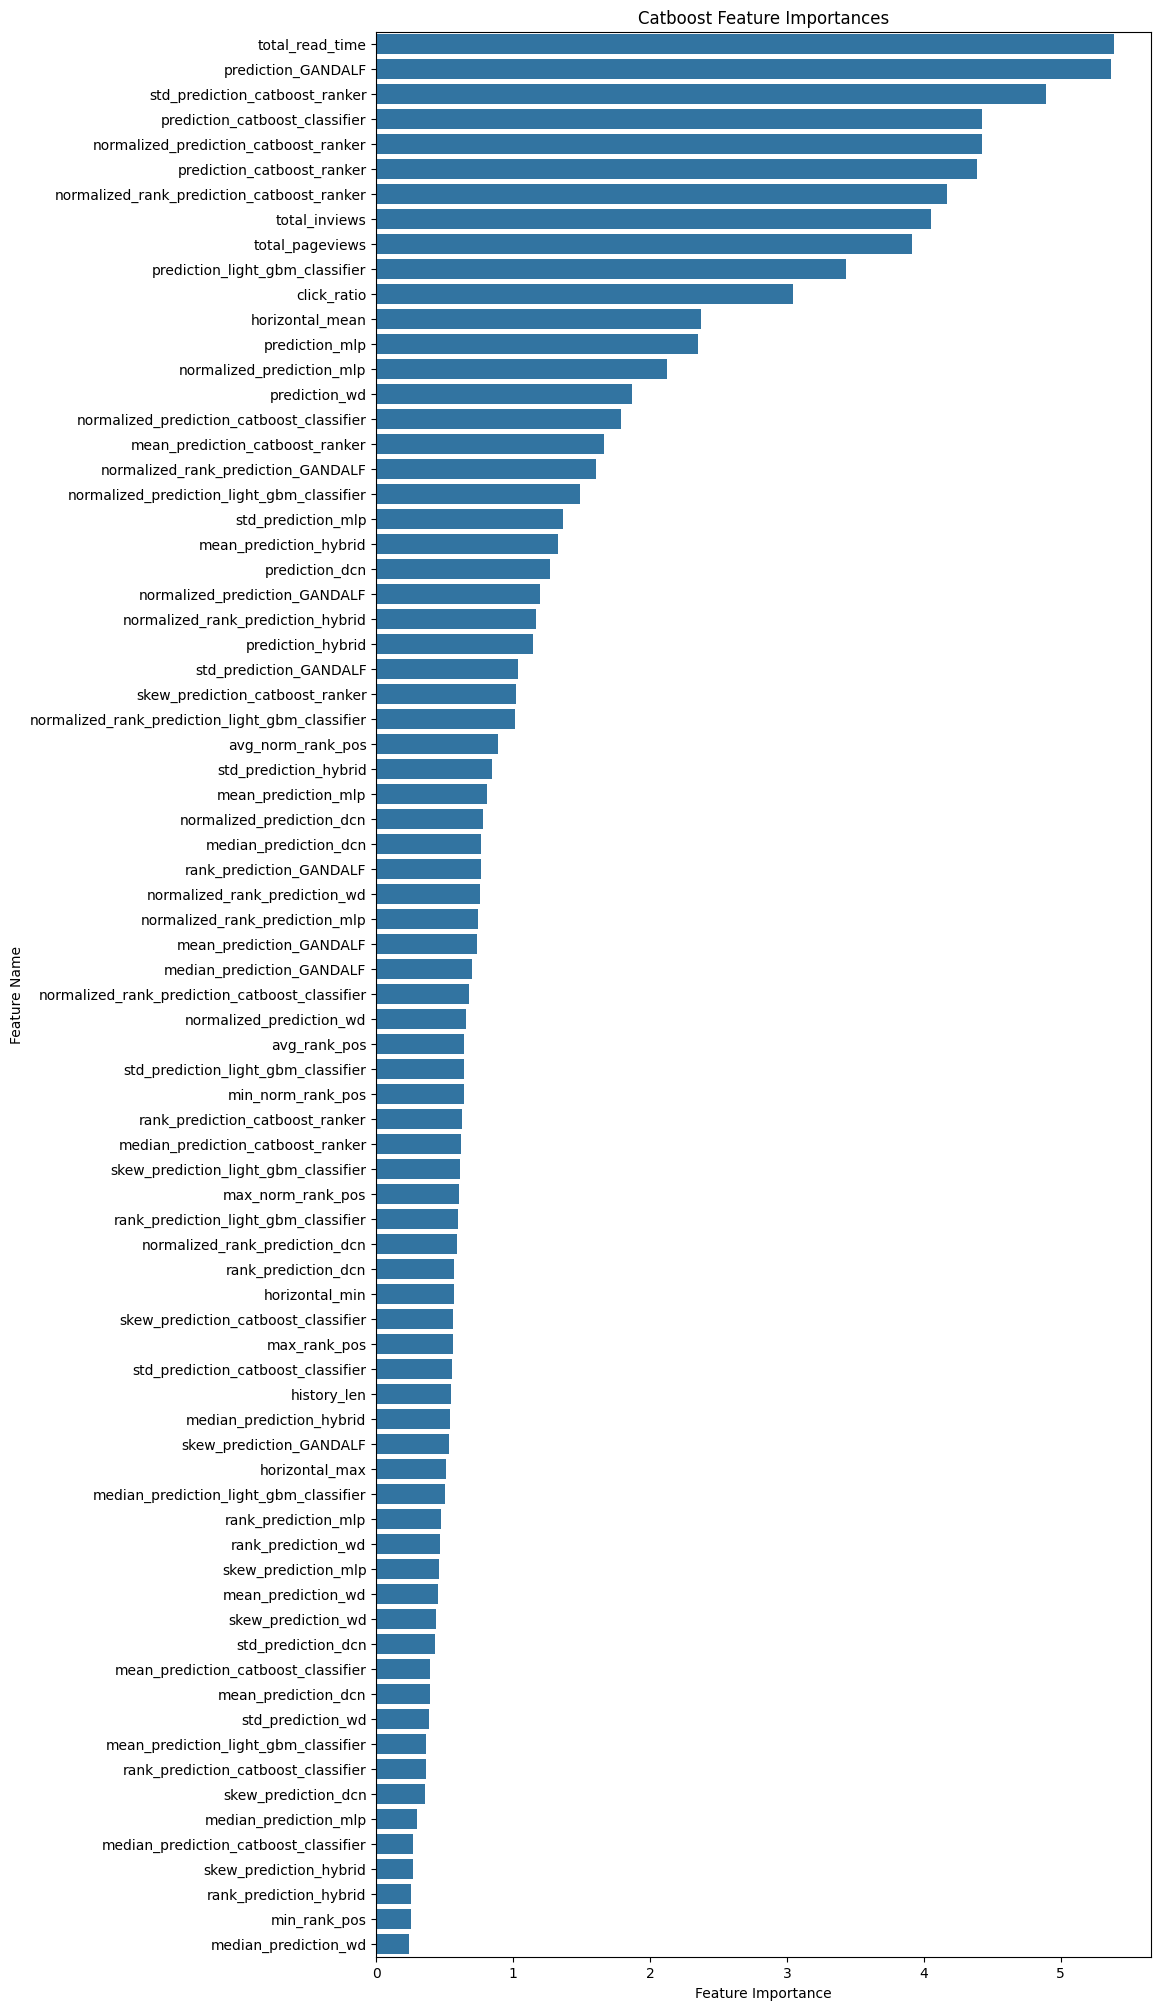

In [47]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 25))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X_train.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [48]:

behaviors_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/behaviors.parquet')
history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/history.parquet')

article_features = articles.select(['article_id','total_inviews','total_pageviews'])

user_features = behaviors_train.select(['impression_id','user_id']).join(history_train.with_columns(
                        pl.col('article_id_fixed').list.len().alias('history_len')
                    ).select(['user_id','history_len']), on='user_id').drop('user_id')


In [49]:
level2_val_df = load_predictions('/home/ubuntu/experiments/hybrid_level2' + '/prediction_level_1_validation', MODEL_LIST)

Loading Predictions for catboost_ranker
Loading Predictions for catboost_classifier
Loading Predictions for light_gbm_classifier
Loading Predictions for mlp
Loading Predictions for GANDALF
Loading Predictions for wd
Loading Predictions for dcn


In [50]:
test = level2_val_df
for model in MODEL_LIST:
    if model in ['mlp', 'GANDALF', 'wd', 'dcn']:
        test = test.with_columns(
                pl.col(f'prediction_{model}').list.first()    
            )

In [51]:
level2_val_df = test.with_columns(
    *[
            ((pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'prediction_{model}').min().over('impression_id'))).alias(f'normalized_prediction_{model}')
            for model in MODEL_LIST
        ]
).with_columns(
    *[(MODEL_WEIGHTS[i] * pl.col(f'normalized_prediction_{MODEL_LIST[i]}')).alias(f'prediction_hybrid_{MODEL_LIST[i]}') for i in range(len(MODEL_LIST))]
).with_columns(
        pl.sum_horizontal([f"prediction_hybrid_{model}" for model in MODEL_LIST]).alias('prediction_hybrid')
).drop( [f'prediction_hybrid_{model}' for model in MODEL_LIST])

level2_val_df = level2_val_df.with_columns(
    *[pl.col(f'prediction_{model}').mean().over('impression_id').alias(f'mean_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').skew().over('impression_id').alias(f'skew_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').std().over('impression_id').alias(f'std_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').median().over('impression_id').alias(f'median_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
    *[pl.col(f'prediction_{model}').rank().over('impression_id').alias(f'rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid']) ],
).rename({'prediction_hybrid' : 'normalized_prediction_hybrid'}).with_columns(    
    pl.mean_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_mean'),
    pl.min_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_min'),
    pl.max_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid']) ]).alias('horizontal_max'),
    pl.mean_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_rank_pos'),
    pl.min_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_rank_pos'),
    pl.max_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_rank_pos'),
).rename({'normalized_prediction_hybrid' : 'prediction_hybrid'}).with_columns(
    pl.col('impression_id').count().over('impression_id').alias('n_articles_impression')
).with_columns(
    *[(pl.col(f'rank_prediction_{model}')/pl.col('n_articles_impression')).alias(f'normalized_rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])]
).drop(['n_articles_impression']).with_columns(
    pl.mean_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_norm_rank_pos'),
    pl.min_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_norm_rank_pos'),
    pl.max_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_norm_rank_pos'),
)


In [52]:
# level2_val_df = level2_val_df.drop(columns=['target']).join(pl.read_parquet('/home/ubuntu/experiments/preprocessing_validation_small_new/validation_ds.parquet'),on = ['impression_id', 'article'], how='left')

In [53]:
level2_val_df

impression_id,article,target,prediction_catboost_ranker,prediction_catboost_classifier,prediction_light_gbm_classifier,prediction_mlp,prediction_GANDALF,prediction_wd,prediction_dcn,normalized_prediction_catboost_ranker,normalized_prediction_catboost_classifier,normalized_prediction_light_gbm_classifier,normalized_prediction_mlp,normalized_prediction_GANDALF,normalized_prediction_wd,normalized_prediction_dcn,prediction_hybrid,mean_prediction_catboost_ranker,mean_prediction_catboost_classifier,mean_prediction_light_gbm_classifier,mean_prediction_mlp,mean_prediction_GANDALF,mean_prediction_wd,mean_prediction_dcn,mean_prediction_hybrid,skew_prediction_catboost_ranker,skew_prediction_catboost_classifier,skew_prediction_light_gbm_classifier,skew_prediction_mlp,skew_prediction_GANDALF,skew_prediction_wd,skew_prediction_dcn,skew_prediction_hybrid,std_prediction_catboost_ranker,std_prediction_catboost_classifier,std_prediction_light_gbm_classifier,std_prediction_mlp,std_prediction_GANDALF,std_prediction_wd,std_prediction_dcn,std_prediction_hybrid,median_prediction_catboost_ranker,median_prediction_catboost_classifier,median_prediction_light_gbm_classifier,median_prediction_mlp,median_prediction_GANDALF,median_prediction_wd,median_prediction_dcn,median_prediction_hybrid,rank_prediction_catboost_ranker,rank_prediction_catboost_classifier,rank_prediction_light_gbm_classifier,rank_prediction_mlp,rank_prediction_GANDALF,rank_prediction_wd,rank_prediction_dcn,rank_prediction_hybrid,horizontal_mean,horizontal_min,horizontal_max,avg_rank_pos,min_rank_pos,max_rank_pos,normalized_rank_prediction_catboost_ranker,normalized_rank_prediction_catboost_classifier,normalized_rank_prediction_light_gbm_classifier,normalized_rank_prediction_mlp,normalized_rank_prediction_GANDALF,normalized_rank_prediction_wd,normalized_rank_prediction_dcn,normalized_rank_prediction_hybrid,avg_norm_rank_pos,min_norm_rank_pos,max_norm_rank_pos
u32,i32,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
96791,9783865,0,-0.581865,0.07266,0.093698,0.164932,0.042458,0.064278,0.076475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33145,0.239505,0.272763,0.359217,0.28837,0.270774,0.241343,0.540928,-0.665784,-0.454278,-0.69147,-0.489786,0.193835,0.185605,0.104031,-0.361365,0.575732,0.115924,0.112246,0.127801,0.182324,0.159931,0.122319,0.359982,0.364859,0.270578,0.288702,0.387571,0.292777,0.252811,0.239868,0.56224,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
96791,9784591,0,0.332211,0.176555,0.271684,0.405962,0.292777,0.205723,0.201436,0.578127,0.356872,0.57581,0.693803,0.487722,0.327027,0.369704,0.491484,0.33145,0.239505,0.272763,0.359217,0.28837,0.270774,0.241343,0.540928,-0.665784,-0.454278,-0.69147,-0.489786,0.193835,0.185605,0.104031,-0.361365,0.575732,0.115924,0.112246,0.127801,0.182324,0.159931,0.122319,0.359982,0.364859,0.270578,0.288702,0.387571,0.292777,0.252811,0.239868,0.56224,2.0,2.0,2.0,4.0,3.0,2.0,2.0,2.0,0.485069,0.327027,0.693803,2.375,2.0,4.0,0.4,0.4,0.4,0.8,0.6,0.4,0.4,0.4,0.475,0.4,0.8
96791,9784679,0,0.542811,0.313949,0.306928,0.387571,0.257047,0.334262,0.274459,0.711326,0.828814,0.689829,0.640863,0.418105,0.624212,0.585748,0.650918,0.33145,0.239505,0.272763,0.359217,0.28837,0.270774,0.241343,0.540928,-0.665784,-0.454278,-0.69147,-0.489786,0.193835,0.185605,0.104031,-0.361365,0.575732,0.115924,0.112246,0.127801,0.182324,0.159931,0.122319,0.359982,0.364859,0.270578,0.288702,0.387571,0.292777,0.252811,0.239868,0.56224,4.0,4.0,4.0,3.0,2.0,4.0,4.0,4.0,0.643727,0.418105,0.828814,3.625,2.0,4.0,0.8,0.8,0.8,0.6,0.4,0.8,0.8,0.8,0.725,0.4,0.8
96791,9784696,1,0.999233,0.363786,0.402803,0.512336,0.5557,0.496797,0.414477,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.33145,0.239505,0.272763,0.359217,0.28837,0

In [54]:
level2_val_df = level2_val_df.join(article_features, left_on='article', right_on='article_id').join(user_features, on='impression_id')

In [55]:
level2_val_df = level2_val_df.with_columns(
    *[
            ((pl.col(field)-pl.col(field).min().over('impression_id')) / 
            (pl.col(field).max().over('impression_id')-pl.col(field).min().over('impression_id')))
            for field in ['total_inviews','total_pageviews']
     ]
).with_columns(
    (pl.col('total_pageviews')/pl.col('total_inviews')).alias('click_ratio')
)

In [56]:
if 'postcode' in level2_val_df.columns:
        level2_val_df = level2_val_df.with_columns(pl.col('postcode').fill_null(5))
if 'article_type' in level2_val_df.columns:
        level2_val_df = level2_val_df.with_columns(pl.col('article_type').fill_null('article_default'))  
if 'impression_time' in level2_val_df.columns:
        level2_val_df = level2_val_df.drop(columns = ['impression_time']) 
        
level2_val_df = level2_val_df.to_pandas()
X_val = level2_val_df[X_train.columns]
evaluation_ds = pl.from_pandas(level2_val_df[['impression_id', 'article', 'target']])
    
if RANKER:
    prediction_ds = evaluation_ds.with_columns(pl.Series(catboost.predict(X_val)).alias('prediction'))\
        .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
else : 
    prediction_ds = evaluation_ds.with_columns(pl.Series(catboost.predict_proba(X_val)[:, 1]).alias('prediction'))\
        .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))

In [60]:
cpp_auc = CppAuc()
result = np.mean(
        [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
            for y_t, y_s in zip(prediction_ds['target'].to_list(), 
                                prediction_ds['prediction'].to_list())]
    )
print(result)

0.8138866080380045


In [58]:
def optimize_parameters(X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, evaluation_ds: pl.DataFrame, 
                        categorical_features: List[str], group_ids: pd.DataFrame, model_class: Type = CatBoostClassifier, 
                        study_name: str = 'catboost_cls_tuning', n_trials: int = 100, storage: str = None) -> Tuple[Dict, pd.DataFrame]:    
    def objective_function(trial: optuna.Trial):
        params = get_models_params(trial, model_class, categorical_features)
        model = model_class(**params)
        if model_class == CatBoostRanker:
            model.fit(X_train, y_train, group_id=group_ids['impression_id'], verbose=50)
        elif model_class in [XGBRanker, LGBMRanker]:
            model.fit(X_train, y_train, group=group_ids.groupby('impression_id')['impression_id'].count().values)
        elif model_class == LGBMClassifier:
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train, verbose=100)
        if model_class in [CatBoostRanker, XGBRanker, LGBMRanker]:
            prediction_ds = evaluation_ds.with_columns(pl.Series(model.predict(X_val)).alias('prediction')) \
                .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
        else:
            prediction_ds = evaluation_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction')) \
                .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
        cpp_auc = CppAuc()
        return np.mean(
            [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
                for y_t, y_s in zip(prediction_ds['target'].to_list(), 
                                    prediction_ds['prediction'].to_list())]
        )
        
    study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage, load_if_exists=True)
    study.optimize(objective_function, n_trials=n_trials, n_jobs=1)
    return study.best_params, study.trials_dataframe()

In [59]:
# best_params, trials_df = optimize_parameters(X_train=X_train, y_train=y_train, X_val=X_val, evaluation_ds=evaluation_ds,
#                                                  categorical_features=[], group_ids=group_ids, model_class=CatBoostClassifier,
#                                                  study_name='test', n_trials=200, storage=None)